In [4]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from cvxopt import solvers, matrix
from tqdm import tqdm
%matplotlib inline

In [5]:
reward1 = np.zeros(shape=(10, 10,))
reward1[2:4, 5:7] = -10
reward1[4:6, 1:3] = -10
reward1[8:10, 2:4] = -10
reward1[9, 9] = 1


reward2 = np.zeros(shape=(10, 10,))
reward2[1:7, 4] = -100
reward2[1, 4:7] = -100
reward2[2, 6] = -100
reward2[3, 6:9] = -100
reward2[3:8, 8] = -100
reward2[8, 6] = -100
reward2[7, 7] = -100
reward2[7:8, 6] = -100
reward2[9, 9] = 10

# Reinforcement Learning (RL)

### QUESTION 1

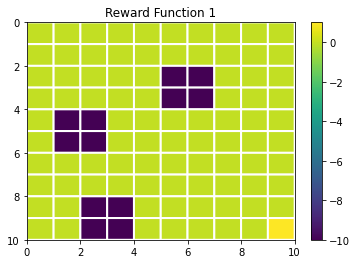

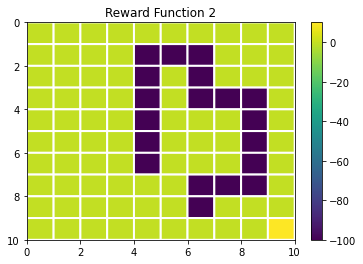

In [15]:
plt.pcolor(reward1, edgecolor="white", linewidths=2)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Reward Function 1")
plt.show()

plt.pcolor(reward2, edgecolor="white", linewidths=2)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Reward Function 2")
plt.show()

### QUESTIONS 2 AND 5

0 is up\
1 is down\
2 is left\
3 is right

S is state_space\
R is reward kernel\
A is set of actions\
policy is optimal policy for each state\
gamma is discount_factor


In [16]:
width, height = 10, 10

S = []
for i in range(height):
    for j in range(width):
        S.append((i, j))

A = np.array([0, 1, 2, 3])
gamma = 0.8
V = np.zeros(shape=(height, width,))
w = 0.1
epsilon = 0.01
POLICY_MAP = {0: u'\u2191', 1: u'\u2193', 2: u'\u2190', 3: u'\u2192'}

snapshots = list()

def state_to_coords(state):
    return (state // width, state % height)

def coords_to_state(x, y):
    return x * width + y

def extract_transition_matrix(w, R):
    trans_mat = np.zeros(shape=(100, 100, 4,))
    for (x, y) in S:
        state = coords_to_state(x, y)
        for action in A:
            for key, trans_prob in transitions((x, y,), action, w, R).items():
                (next_x, next_y), _ = key
                next_state = coords_to_state(next_x, next_y)
                trans_mat[state, next_state, action] = trans_prob
    return trans_mat

def step(state, action, R):
    """
    Gives the next state and reward for an action.
    """
    x, y = state
    if action == 0 and x > 0:
        x -= 1
    elif action == 1 and x < height - 1:
        x += 1
    elif action == 2 and y > 0:
        y -= 1
    elif action == 3 and y < width - 1:
        y += 1
    
    next_state = (x, y,)
    return next_state, R[next_state]

def transitions(state, action, w, R):
    """
    Gives all possible {(next_state, reward): trans_prob} of the action.
    """
    trans = collections.defaultdict(lambda:0.0)
    for a in A:
        next_state, reward = step(state, a, R)
        if a == action:
            trans[(next_state, reward)] += 1 - 3 / 4 * w
        else:
            trans[(next_state, reward)] += w / 4
    return trans

def transPolicy(policy, num_actions, w):
    n, m = policy.shape[0], policy.shape[1]
    transition = np.zeros((n * m, n * m))
    for r in range(n):
        for c in range(m):
            cur_state_index = r + c * n
            opt_action = policy[r][c]
            for a in A:
                (next_r, next_c), _ = step((r,c), a, reward1)
                trans_prob = 0
                if a == opt_action:
                    trans_prob += 1 - (3 / 4 * w)
                else:
                    trans_prob += w/4
                next_state_index = next_r + next_c * n
                transition[cur_state_index][next_state_index] += trans_prob
    print(len(transition), len(transition[0]))
    return transition

def value_update(w, R, state, A, gamma):
    a, v = None, float("-inf")
    for action in A:
        new_v = 0.0
        for key, trans in transitions(state, action, w, R).items():
            next_state, reward = key
            new_v += trans * (reward + gamma * V[next_state])
        if new_v > v:
            a, v = action, new_v
    return a, v

def value_iteration(w, epsilon, V, R, S, A, gamma):

    # Initialization step
    delta = float("inf")
    num_iter = 0

    # Estimation step
    while delta > epsilon:
        delta = 0
        for state in S:
            _, v = value_update(w, R, state, A, gamma)
            delta = max(delta, np.abs(v - V[state]))
            V[state] = v
        num_iter += 1
        if num_iter in [1, 6, 11, 16, 21]:
            snapshots.append(np.copy(V))

    # Computation step
    policy = np.zeros((height, width, ))
    for state in S:
        a, _ = value_update(w, R, state, A, gamma)
        policy[state] = a
    return V, num_iter, policy

In [17]:
opt_val1, num_iter, policy1 = value_iteration(w, epsilon, V, reward1, S, A, gamma)
print(num_iter)
print(policy1)

21
[[3. 3. 3. 3. 3. 3. 3. 3. 1. 1.]
 [3. 3. 3. 0. 0. 0. 3. 3. 1. 1.]
 [3. 3. 3. 0. 0. 0. 3. 3. 1. 1.]
 [0. 0. 3. 1. 1. 1. 1. 3. 1. 1.]
 [0. 0. 3. 3. 1. 1. 1. 1. 1. 1.]
 [1. 1. 3. 3. 1. 1. 1. 1. 1. 1.]
 [1. 3. 3. 3. 3. 3. 3. 1. 1. 1.]
 [3. 3. 3. 3. 3. 3. 3. 3. 1. 1.]
 [0. 0. 0. 3. 3. 3. 3. 3. 3. 1.]
 [0. 2. 2. 3. 3. 3. 3. 3. 3. 1.]]


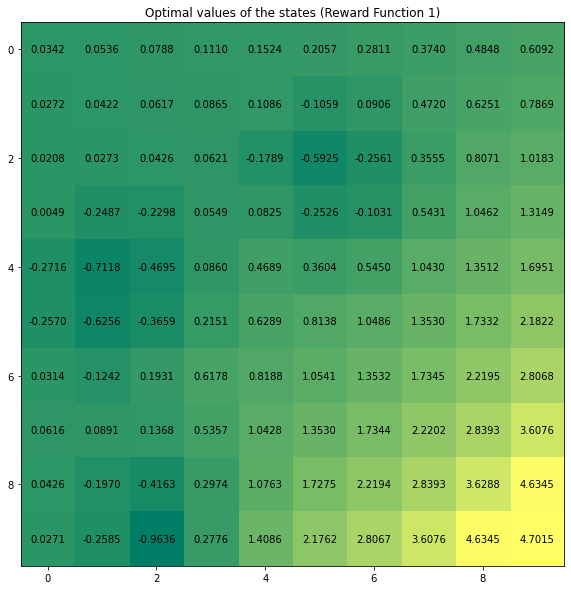

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(opt_val1,cmap="summer")
for i in range(10):
    for j in range(10):
        c = "{:.4f}".format(opt_val1[i,j])
        ax.text(j, i, str(c), va='center', ha='center')
plt.title("Optimal values of the states (Reward Function 1)")
plt.show()

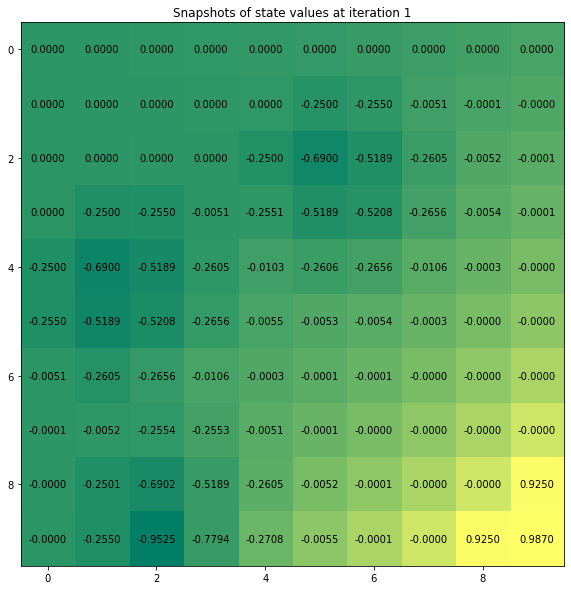

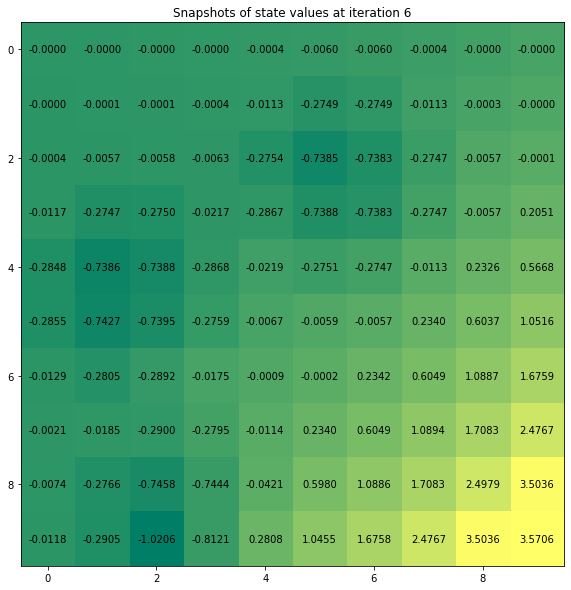

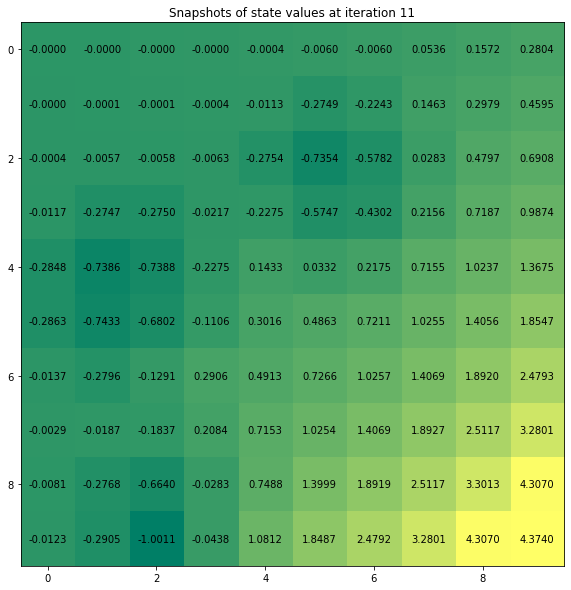

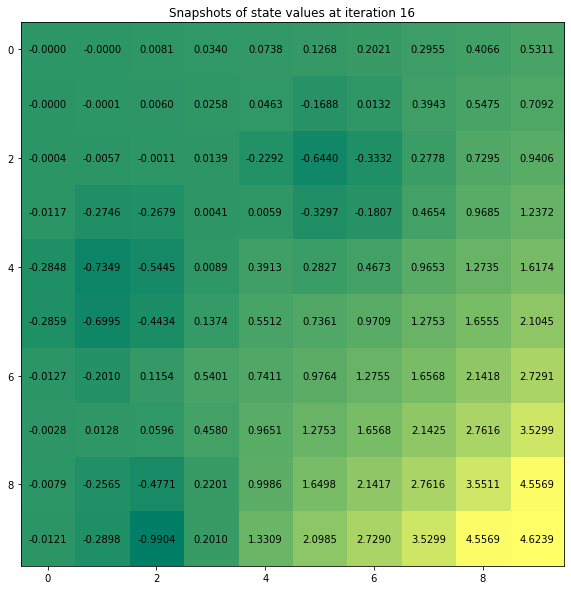

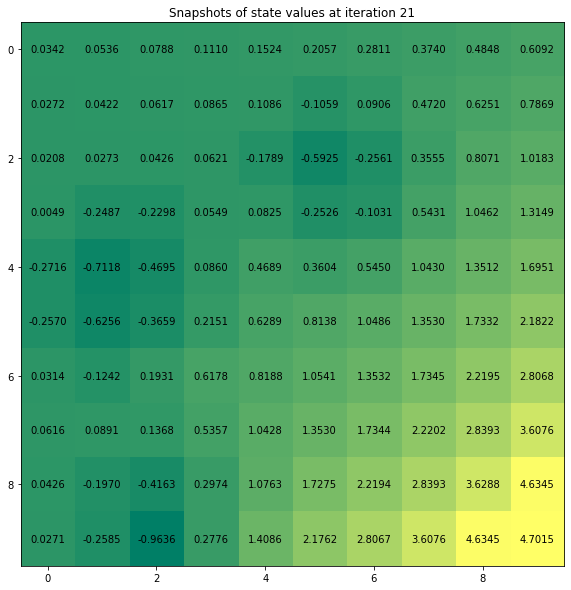

In [19]:
max_val, min_val = np.max(opt_val1), np.min(opt_val1)
iters = [1, 6, 11, 16, 21]
for k in range(len(snapshots)):
    snapshot = snapshots[k]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(opt_val1, vmax = max_val, vmin = min_val, cmap="summer")
    for i in range(10):
        for j in range(10):
            c = "{:.4f}".format(snapshot[i,j])
            ax.text(j, i, str(c), va='center', ha='center')
    plt.title("Snapshots of state values at iteration {}".format(iters[k]))
    plt.show()

### QUESTION 3

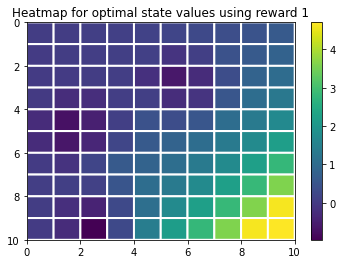

In [20]:
plt.pcolor(opt_val1, edgecolors='white', linewidths=2)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heatmap for optimal state values using reward 1")
plt.show()

### QUESTION 5

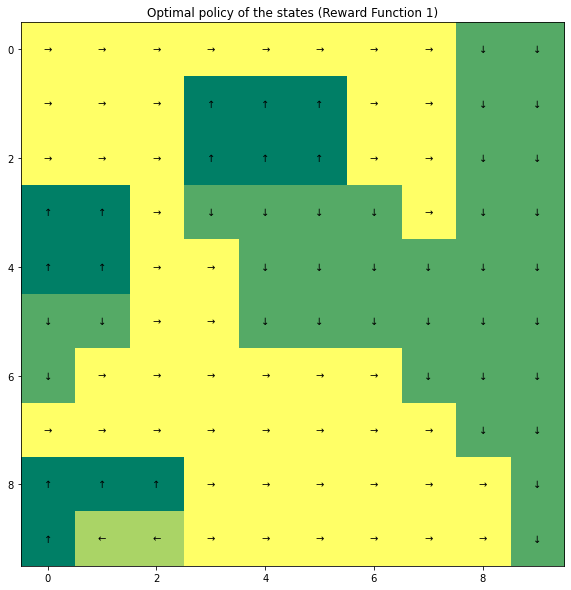

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(policy1,cmap="summer")
for i in range(10):
    for j in range(10):
        c = "{}".format(POLICY_MAP[policy1[i,j]])
        ax.text(j, i, str(c), va='center', ha='center')
plt.title("Optimal policy of the states (Reward Function 1)")
plt.show()

### QUESTION 6

In [22]:
opt_val2, num_iter, policy2 = value_iteration(w, epsilon, V, reward2, S, A, gamma)
print(num_iter)

31


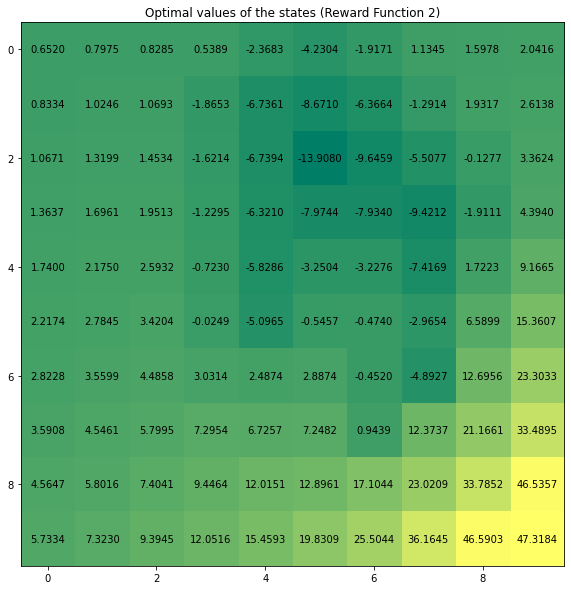

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(opt_val2,cmap="summer")
for i in range(10):
    for j in range(10):
        c = "{:.4f}".format(opt_val2[i,j])
        ax.text(j, i, str(c), va='center', ha='center')
plt.title("Optimal values of the states (Reward Function 2)")
plt.show()

### QUESTION 7

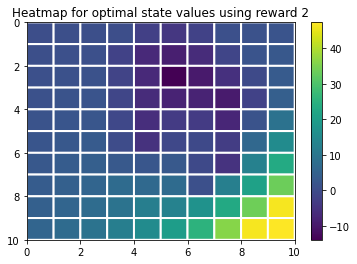

In [24]:
plt.pcolor(opt_val2, edgecolors='white', linewidths=2)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heatmap for optimal state values using reward 2")
plt.show()

### QUESTION 8

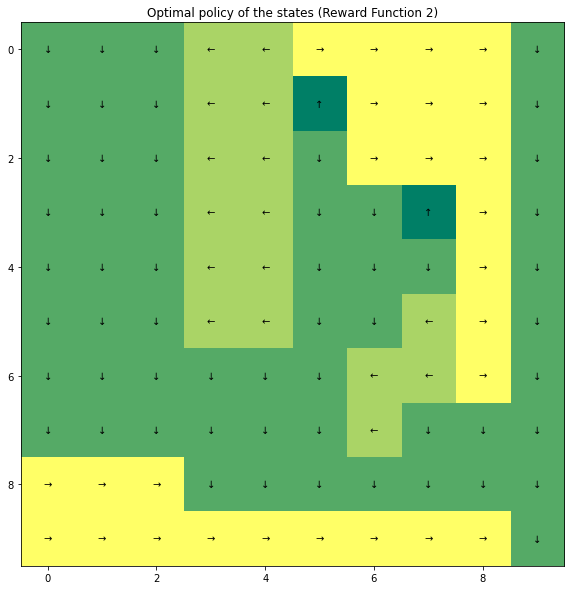

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(policy2,cmap="summer")
for i in range(10):
    for j in range(10):
        c = "{}".format(POLICY_MAP[policy2[i,j]])
        ax.text(j, i, str(c), va='center', ha='center')
plt.title("Optimal policy of the states (Reward Function 2)")
plt.show()

### QUESTION 9

In [26]:
w2 = 0.6
opt_val1, num_iter, policy1 = value_iteration(w2, epsilon, V, reward1, S, A, gamma)
print(num_iter)

25


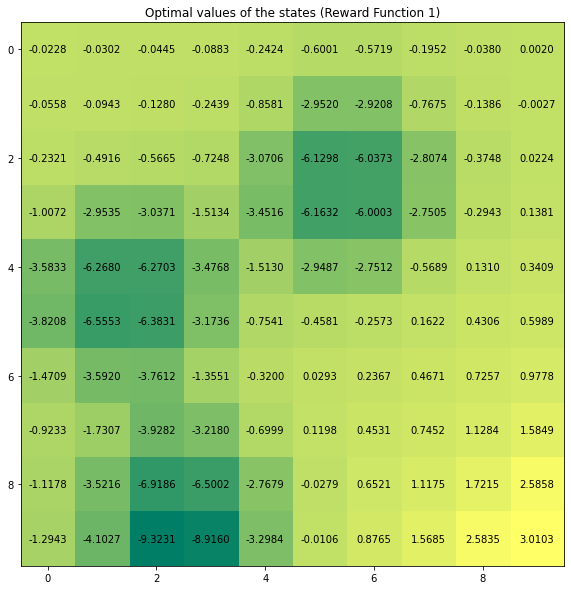

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(opt_val1,cmap="summer")
for i in range(10):
    for j in range(10):
        c = "{:.4f}".format(opt_val1[i,j])
        ax.text(j, i, str(c), va='center', ha='center')
plt.title("Optimal values of the states (Reward Function 1)")
plt.show()

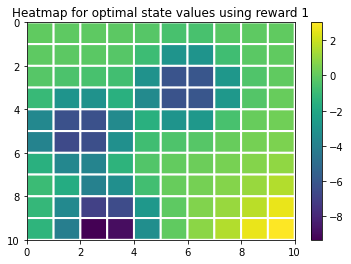

In [28]:
plt.pcolor(opt_val1, edgecolors='white', linewidths=2)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heatmap for optimal state values using reward 1")
plt.show()

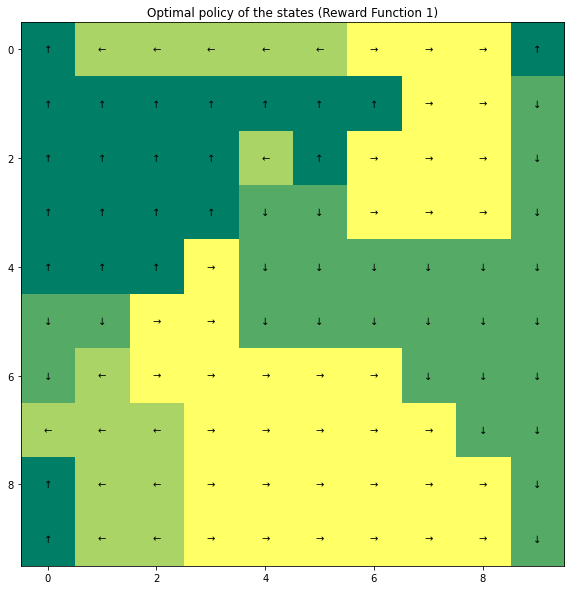

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(policy1,cmap="summer")
for i in range(10):
    for j in range(10):
        c = "{}".format(POLICY_MAP[policy1[i,j]])
        ax.text(j, i, str(c), va='center', ha='center')
plt.title("Optimal policy of the states (Reward Function 1)")
plt.show()

In [30]:
opt_val2, num_iter, policy2 = value_iteration(w2, epsilon, V, reward2, S, A, gamma)
print(num_iter)

21


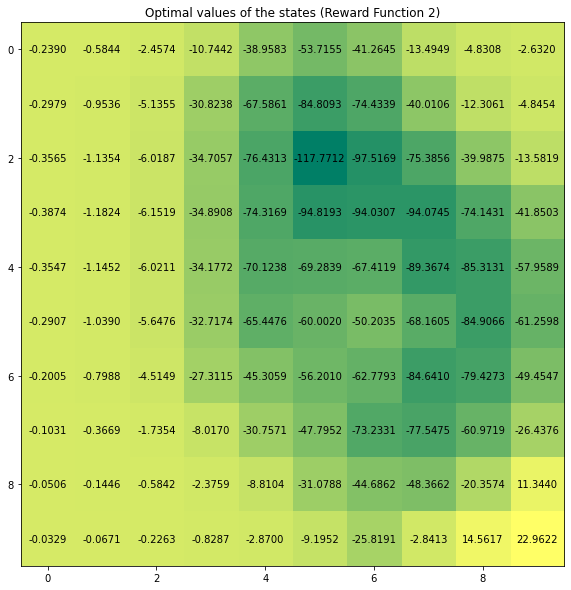

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(opt_val2,cmap="summer")
for i in range(10):
    for j in range(10):
        c = "{:.4f}".format(opt_val2[i,j])
        ax.text(j, i, str(c), va='center', ha='center')
plt.title("Optimal values of the states (Reward Function 2)")
plt.show()

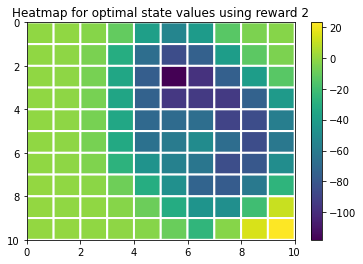

In [32]:
plt.pcolor(opt_val2, edgecolors='white', linewidths=2)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heatmap for optimal state values using reward 2")
plt.show()

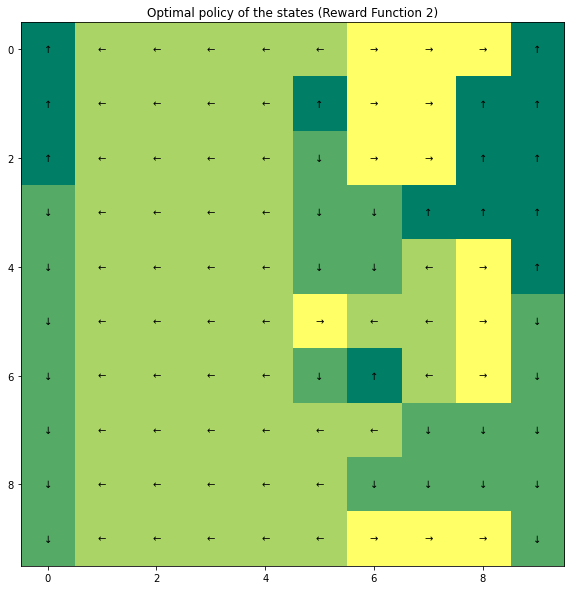

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(policy2,cmap="summer")
for i in range(10):
    for j in range(10):
        c = "{}".format(POLICY_MAP[policy2[i,j]])
        ax.text(j, i, str(c), va='center', ha='center')
plt.title("Optimal policy of the states (Reward Function 2)")
plt.show()

# Inverse Reinforcement Learning (IRL)

### Question 10

In [34]:
t = extract_transition_matrix(w, reward1)
t_d = t[:,:,3]
t_u = t[:,:,2]
t_r = t[:,:,1]
t_l = t[:,:,0]
P_ss = [t_u, t_d, t_l, t_r]

### Helper functions for Q12-24

In [38]:
def diffPolicy(P_a1, P_a2,gamma):
    return np.dot((P_a1-P_a2), np.linalg.inv(np.identity(P_a1.shape[0])-gamma*P_a1))

def cdbMat(policy, r_max, num_actions, gamma, random_action_prob):
    
    P_a1 = transPolicy(policy, num_actions, random_action_prob)
    P_a2 = transPolicy(np.mod(policy+1,num_actions), num_actions, random_action_prob)
    P_a3 = transPolicy(np.mod(policy+2,num_actions), num_actions, random_action_prob)
    P_a4 = transPolicy(np.mod(policy+3,num_actions), num_actions, random_action_prob)
    # P_a1 = t[:,:,3]
    # P_a2 = t[:,:,2]
    # P_a3 = t[:,:,1]
    # P_a4 = t[:,:,0]

    N = np.ma.size(policy)
    Iden = np.identity(N)
    zeroN = np.zeros((N,N))

    D = np.concatenate(
        [np.concatenate([Iden, zeroN, -diffPolicy(P_a1, P_a2, gamma)],axis=1),
         np.concatenate([Iden, zeroN, -diffPolicy(P_a1, P_a3, gamma)],axis=1),
         np.concatenate([Iden, zeroN, -diffPolicy(P_a1, P_a4, gamma)],axis=1),
         np.concatenate([zeroN, zeroN, -diffPolicy(P_a1, P_a2, gamma)],axis=1),
         np.concatenate([zeroN, zeroN, -diffPolicy(P_a1, P_a3, gamma)],axis=1),
         np.concatenate([zeroN, zeroN, -diffPolicy(P_a1, P_a4, gamma)],axis=1),
         np.concatenate([zeroN, -Iden, Iden],axis=1),
         np.concatenate([zeroN, zeroN, Iden],axis=1),
         np.concatenate([zeroN, zeroN, Iden],axis=1),
         np.concatenate([zeroN, zeroN, -Iden],axis=1)],axis=0
        )
    
    b = np.concatenate([np.zeros((8*N,)), r_max*np.ones((2*N,))])
    
    return D, b

def IRL_main(name, epsilon, w, gamma, reward, rmax, *args, **kwargs):
    N = 100
    lambda_list = np.linspace(0,5,500)
    acc_list = np.zeros(500)

    V_new, num, P = value_iteration(
        w=w,
        epsilon=epsilon,
        V=V,
        R=reward,
        S=S,
        A=A,
        gamma=gamma
    )

    D, b = cdbMat(P,rmax,4,gamma,w)

    def T(D, b):
      """
      An often used dot product in LP formation
      """
      solvers.options['show_progress']=False
      c = np.concatenate([np.ones((N,)), -L*np.ones((N,)), np.zeros((N,))])
      sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
      opt_x = np.array(sol['x'])
      R = np.transpose(np.reshape(opt_x[200:],(10,10)))
      return R


    for i,L in enumerate(lambda_list):
        R = T(D, b)
        v, Nn, p = value_iteration(w, epsilon, V, R, S, A, gamma)
        accuracy = np.sum(P==p)/p.size
        acc_list[i] = accuracy

    # Plot lambda against accuracy
    plt.plot(lambda_list,acc_list)
    plt.xlabel('Lambda')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy vs. Lambda for {name}")
    plt.show()

    # Find best lambda and accuracy
    best_lambda = max(lambda_list[acc_list==np.max(acc_list)])
    print(f"Best Lambda: {best_lambda:.4f}")
    print(f"Max Accuracy: {max(acc_list):.4f}")

    D_opt, b_opt = cdbMat(P,rmax,4,gamma,w)
    R_opt = T(D_opt, b_opt)
    # Compare derived policy against ground truth policy
    v_best_lambda, _, p_best_lambda = value_iteration(w, epsilon, V, R_opt, S, A, gamma)
    v_ground_truth, _, p_ground_truth = value_iteration(w, epsilon, V, reward, S, A, gamma)
    accuracy = np.sum(p_ground_truth == p_best_lambda)/p_ground_truth.size
    print(f"Accuracy for Derived {name}: {accuracy:.3f}")

    # Heatmap for obtained reward
    plt.pcolor(R_opt, edgecolors='white', linewidths=2)
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.title(f"Heatmap for Obtained {name}")
    plt.show()

    # True heatmap reward
    plt.pcolor(reward, edgecolors='white', linewidths=2)
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.title(f"Heatmap for {name}")
    plt.show()

    # Optimal values for obtained reward
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(v_best_lambda,cmap="summer")
    for i in range(10):
        for j in range(10):
            c = "{:.4f}".format(v_best_lambda[i,j])
            ax.text(j, i, str(c), va='center', ha='center')
    plt.title(f"Optimal Values For Obtained {name}")
    plt.show()

    # Policy for obtained reward
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(p_best_lambda,cmap="summer")
    for i in range(10):
        for j in range(10):
            c = "{}".format(POLICY_MAP[p_best_lambda[i,j]])
            ax.text(j, i, str(c), va='center', ha='center')
    plt.title(f"Policy For Obtained {name}")
    plt.show()

    # Plot true policy
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(p_ground_truth,cmap="summer")
    for i in range(10):
        for j in range(10):
            c = "{}".format(POLICY_MAP[p_ground_truth[i,j]])
            ax.text(j, i, str(c), va='center', ha='center')
    plt.title(f"True Policy For {name}")
    plt.show()

### Questions 12 - 17

100 100
100 100
100 100
100 100


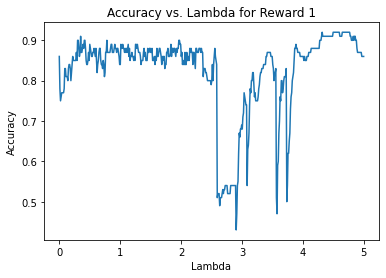

Best Lambda: 4.7695
Max Accuracy: 0.9200
100 100
100 100
100 100
100 100
Accuracy for Derived Reward 1: 0.830


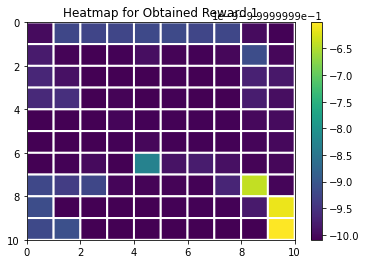

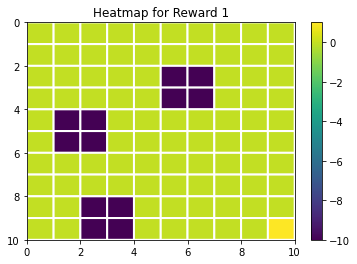

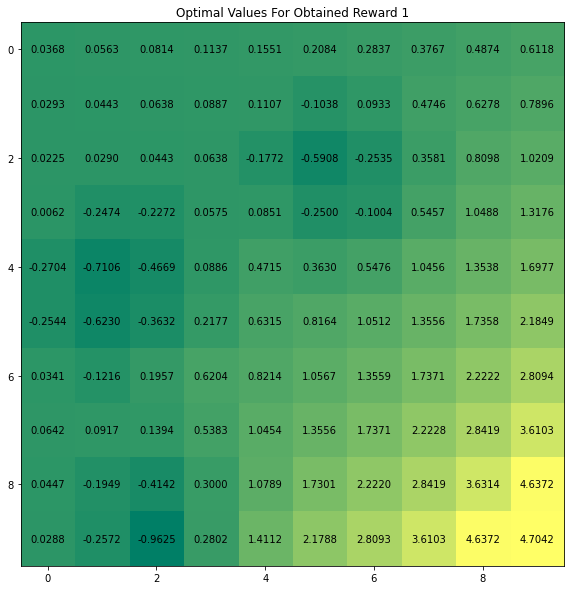

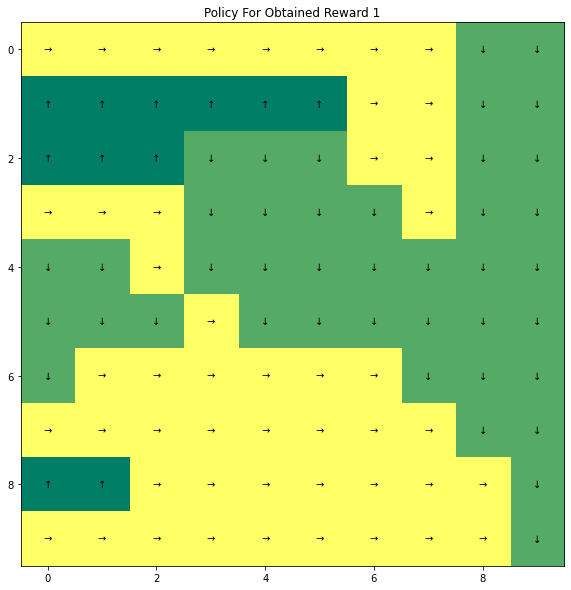

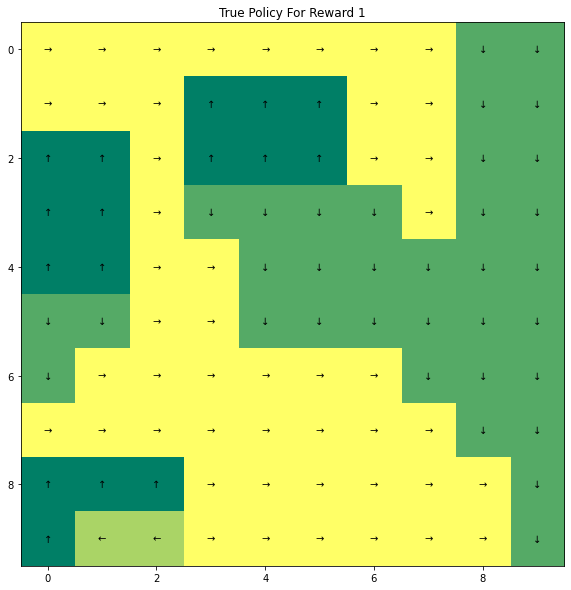

In [39]:
IRL_main(name="Reward 1", epsilon=0.01, w=0.1, gamma=0.8, reward=reward1, rmax=1)

### Questions 18 - 24

100 100
100 100
100 100
100 100


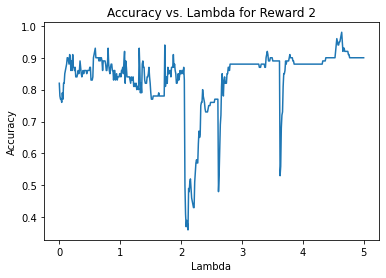

Best Lambda: 4.6393
Max Accuracy: 0.9800
100 100
100 100
100 100
100 100
Accuracy for Derived Reward 2: 0.900


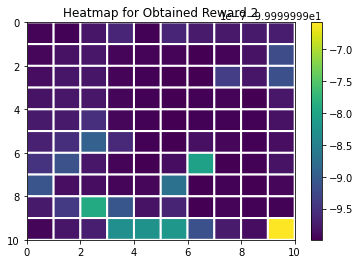

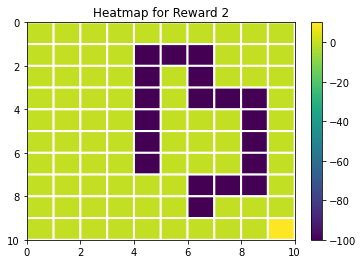

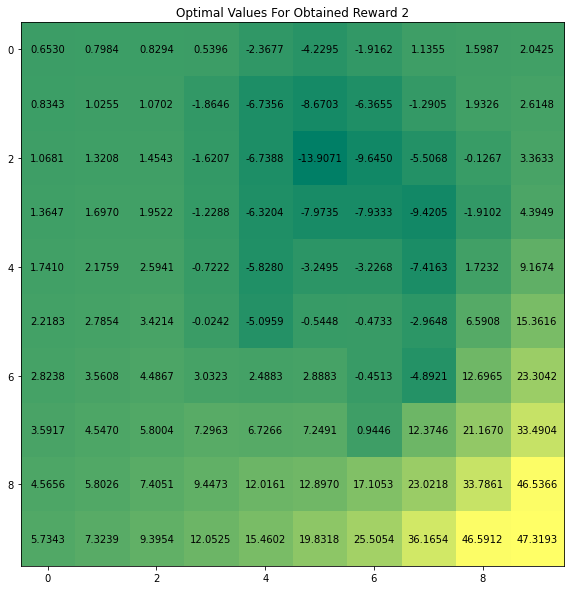

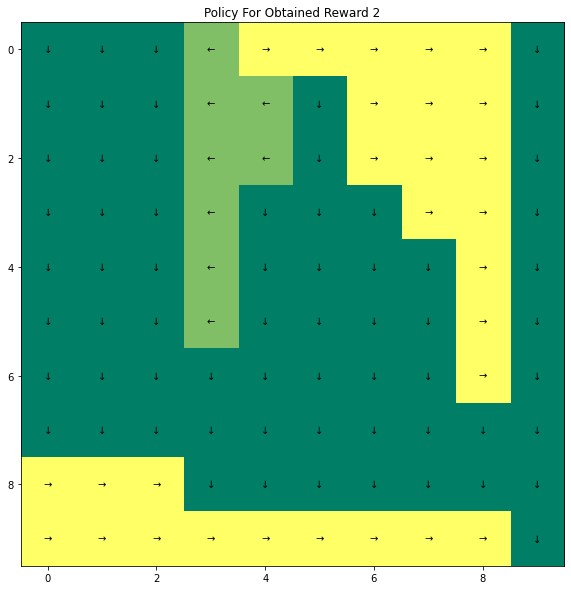

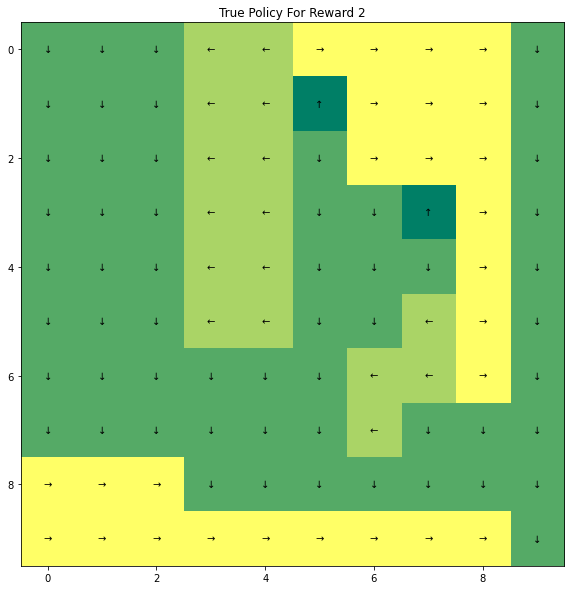

In [40]:
IRL_main(name="Reward 2", epsilon=0.01, w=0.1, gamma=0.8, reward=reward2, rmax=100)

### Question 25

100 100
100 100
100 100
100 100


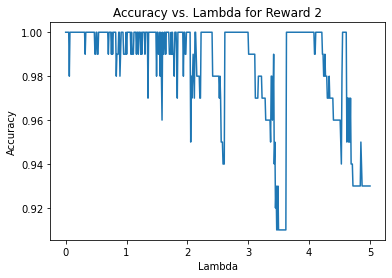

Best Lambda: 4.6092
Max Accuracy: 1.0000
100 100
100 100
100 100
100 100
Accuracy for Derived Reward 2: 0.930


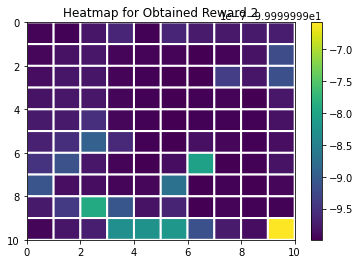

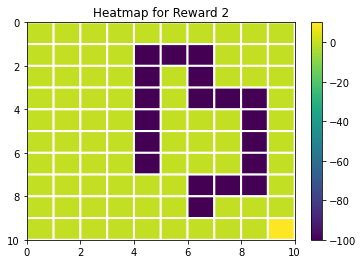

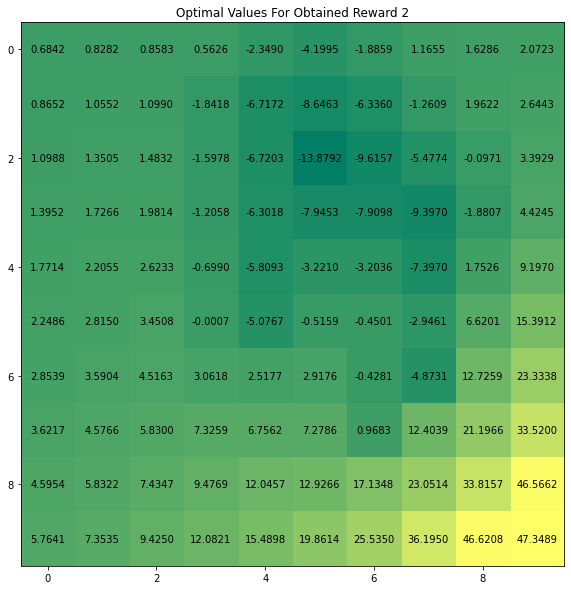

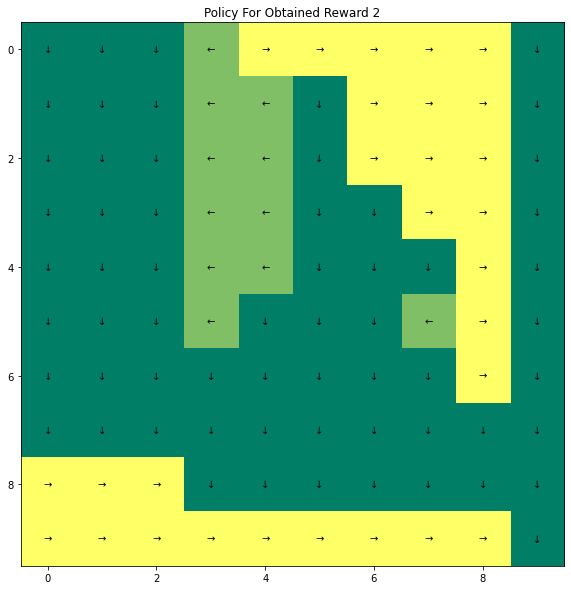

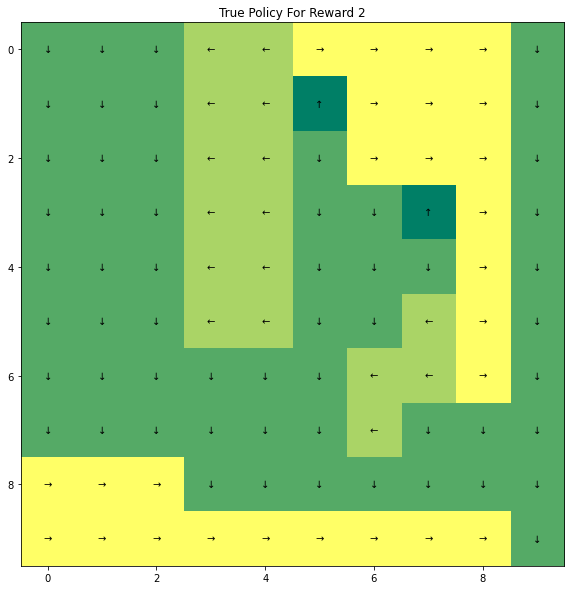

In [44]:
# change epsilon from 0.01 to 10^-8
IRL_main(name="Reward 2", epsilon=pow(10,-8), w=0.1, gamma=0.8, reward=reward2, rmax=100)

100 100
100 100
100 100
100 100


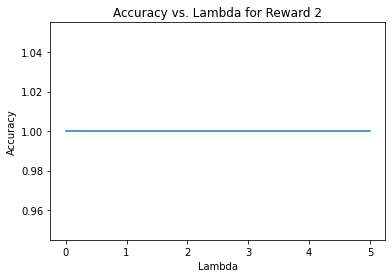

Best Lambda: 5.0000
Max Accuracy: 1.0000
100 100
100 100
100 100
100 100
Accuracy for Derived Reward 2: 1.000


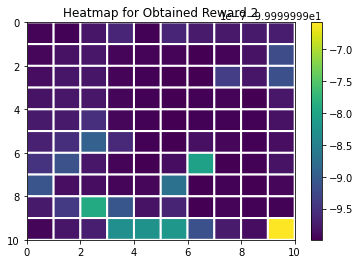

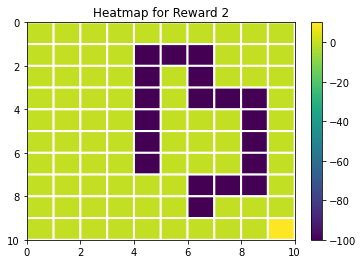

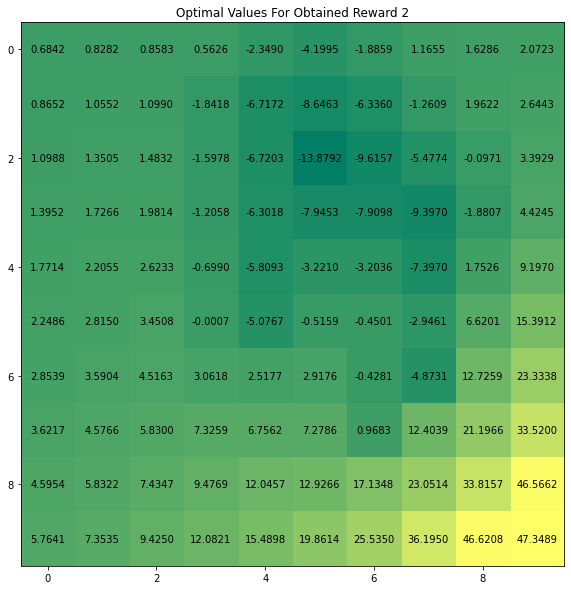

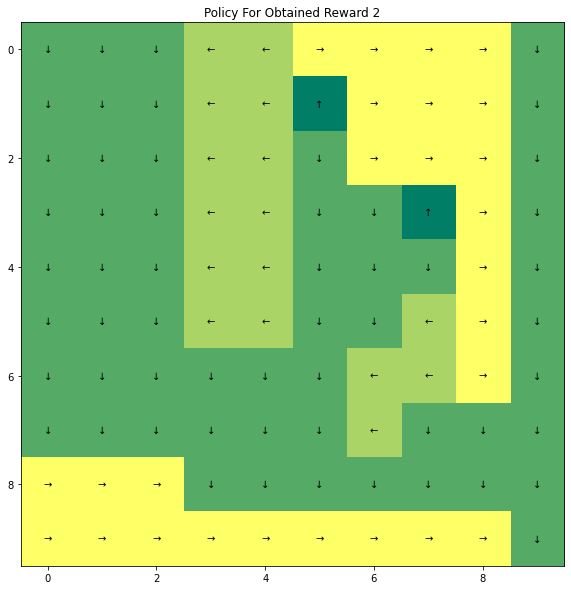

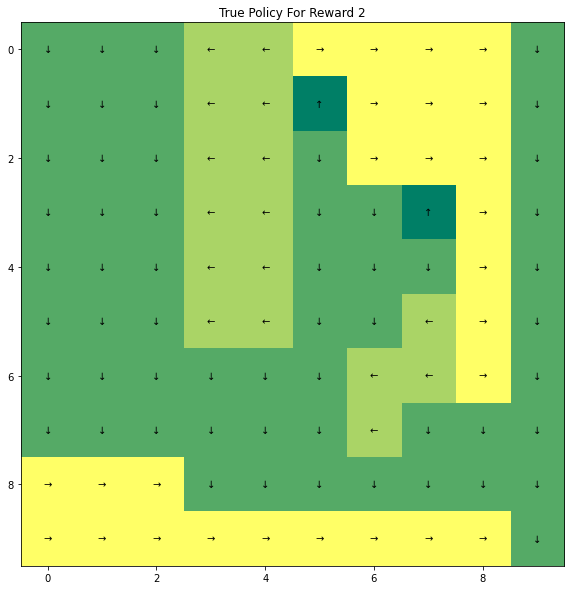

In [45]:
# change epsilon from 0.01 to 10^-10
IRL_main(name="Reward 2", epsilon=pow(10,-10), w=0.1, gamma=0.8, reward=reward2, rmax=100)